# Guide
- This notebook can be used to calculate the similarity of the outputs from the Qwen and Gemma models.
1. Put all the JSON outputs from Qwen in one folder, and from Gemma in another folder.
NOTE: The names of the JSON files in the both folders must be similar so that the program knows which two files to compare. i.e. if the Qwen folders has files named a.json, b.json, c.json; the Gemma folder should also have the same.
2. After the folders have been setup, scroll down to the 'Main Loop' section of the notebook and set the variables to the saved directories and run all the cells.
3. A sample data has also been included.

# Setup

In [ ]:
!pip install -q sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 892.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 112.5 MB/s eta 0:00:00


In [ ]:
import json
import os
import csv
import pandas as pd
from pathlib import Path
from typing import Dict, Any, List, Tuple, Optional
import numpy as np
from dataclasses import dataclass
import logging
import torch
import difflib
import numpy as np
from sentence_transformers import SentenceTransformer, util
from enum import Enum

# This will download a finetuned embedding model which will be used to calculate
# the cosine similarity of the CoT keys in the JSON
!gdown --id 12sDkMerV-OAQT34cTh2XZXh8KZYu2mDV -O embedding_model.zip
!unzip embedding_model.zip

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=12sDkMerV-OAQT34cTh2XZXh8KZYu2mDV
From (redirected): https://drive.google.com/uc?id=12sDkMerV-OAQT34cTh2XZXh8KZYu2mDV&confirm=t&uuid=262ca5be-55bb-45bc-9696-dff2f4cb08dc
To: /content/embedding_model.zip
100% 83.5M/83.5M [00:00<00:00, 110MB/s]
Archive:  embedding_model.zip
   creating: fine_tuned_miniLM_triplet/
   creating: fine_tuned_miniLM_triplet/1_Pooling/
  inflating: fine_tuned_miniLM_triplet/1_Pooling/config.json  
  inflating: fine_tuned_miniLM_triplet/config.json  
  inflating: fine_tuned_miniLM_triplet/config_sentence_transformers.json  
  inflating: fine_tuned_miniLM_triplet/model.safetensors  
  inflating: fine_tuned_miniLM_triplet/modules.json  
  inflating: fine_tuned_miniLM_triplet/README.md 

If the code doesn't work, then manually download and unzip the model from here: https://drive.google.com/file/d/12sDkMerV-OAQT34cTh2XZXh8KZYu2mDV/view?usp=drive_link

In [ ]:
#Load the model
MODEL_PATH = r"/content/fine_tuned_miniLM_triplet"
embedder = SentenceTransformer(MODEL_PATH)

### Downloading sample data


In [ ]:
!gdown --id 17dlaMj7TN8_QIA1_-5a_BSaK4WqP2NCS -O gemma_json.zip
!unzip gemma_json.zip

!gdown --id 1z-WKbavRSWJxqcjO4cbXn9atplzIZGd6 -O qwen_json.zip
!unzip qwen_json.zip

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=17dlaMj7TN8_QIA1_-5a_BSaK4WqP2NCS
To: /content/gemma_json.zip
100% 15.2k/15.2k [00:00<00:00, 56.1MB/s]
Archive:  gemma_json.zip
   creating: gemma_json/
  inflating: gemma_json/01_20240518001302_00005335_F_11_BPK1154_01_jpg.rf.ea506c59a76ee0807d75a82b26d2f5ee_detections.json  
  inflating: gemma_json/01_20240518001601_00005363_F_11_BRG8173_01_jpg.rf.6a51a683d4a869a5efa5e80aa4d942b2_detections.json  
  inflating: gemma_json/01_20240518001914_00005382_F_11_VHX2704_01_jpg.rf.b00a78230729a7d3b9ba23eaf9498318_detections.json  
  inflating: gemma_json/01_20240518012340_00005659_F_11_PMG9838_01_jpg.rf.f047d36ebb6024ec5d47066f28aff3a1_detections.json  
  inflating: gemma_json/01_20240518015254_00005762_F_11_PJG9406_01_jpg.rf.

# Define category hierarchy and similarity mappings
These are similarity scores that have been manually assigned between different categories.

In [ ]:

CATEGORY_HIERARCHY = {
    "Car": ["Sedan", "Hatchback", "Coupe", "Convertible", "Sports"],
    "SUV": ["Compact_SUV", "Mid-Size_SUV", "Full-Size_SUV", "Crossover"],
    "MPV_Small": ["Compact_MPV", "Minivan"],
    "MPV_Big": ["Large_MPV", "7-Seater_MPV"],
    "Pickup_Truck": ["Regular_Cab", "Extended_Cab", "Crew_Cab"],
    "Bus": ["City_Bus", "Coach", "School_Bus"],
    "Motorcycle": ["Motorbike", "Scooter"],
    "Vans": ["Cargo_Van", "Passenger_Van"],
    "Small_Truck": ["2-Axle_Small", "2-Axle_Big"],
    "Medium_Truck": ["3-Axle_Medium"],
    "Large_Truck": ["4-Axle_Large"],
    "Heavy_Truck": ["5+_Axle_Heavy"],
    "Construction_and_Industrial": ["Bulldozer", "Excavator", "Crane", "Forklift", "Dump_Truck", "Mixer"],
    "Tanker": ["Fuel_Tanker", "Chemical_Tanker", "Gas_Tanker"],
    "Container": ["20ft_Container", "40ft_Container"],
    "Trailer": ["Flatbed_Trailer", "Car_Carrier", "Lowboy_Trailer", "Refrigerator_Trailer"],
    "Unclassified": []
}

# Define category similarity groups with similarity scores
CATEGORY_SIMILARITY_GROUPS = {
    # Passenger vehicles
    ("Car", "SUV"): 0.7,
    ("Car", "MPV_Small"): 0.5,
    ("SUV", "MPV_Small"): 0.6,
    ("SUV", "MPV_Big"): 0.6,
    ("SUV", "Pickup_Truck"): 0.4,

    # Multi-purpose vehicles
    ("MPV_Small", "MPV_Big"): 0.7,
    ("MPV_Small", "Vans"): 0.5,
    ("MPV_Big", "Vans"): 0.7,
    ("MPV_Small", "Bus"): 0.1,
    ("MPV_Big", "Bus"): 0.1,

    # Commercial light vehicles
    ("Pickup_Truck", "Small_Truck"): 0.6,
    ("Pickup_Truck", "Vans"): 0.2,
    ("Vans", "Small_Truck"): 0.2,

    # Commercial trucks (progressive similarity)
    ("Small_Truck", "Medium_Truck"): 0.8,
    ("Medium_Truck", "Large_Truck"): 0.8,
    ("Large_Truck", "Heavy_Truck"): 0.8,
    ("Small_Truck", "Large_Truck"): 0.5,
    ("Small_Truck", "Heavy_Truck"): 0.4,
    ("Medium_Truck", "Heavy_Truck"): 0.6,

    # Heavy commercial/industrial
    ("Heavy_Truck", "Construction_and_Industrial"): 0.7,
    ("Heavy_Truck", "Tanker"): 0.6,
    ("Heavy_Truck", "Container"): 0.6,
    ("Heavy_Truck", "Trailer"): 0.5,
    ("Large_Truck", "Construction_and_Industrial"): 0.6,
    ("Large_Truck", "Tanker"): 0.7,
    ("Large_Truck", "Container"): 0.7,
    ("Large_Truck", "Trailer"): 0.6,
    ("Medium_Truck", "Construction_and_Industrial"): 0.4,
    ("Medium_Truck", "Tanker"): 0.5,
    ("Medium_Truck", "Container"): 0.5,

    # Specialized commercial vehicles
    ("Construction_and_Industrial", "Tanker"): 0.5,
    ("Construction_and_Industrial", "Container"): 0.4,
    ("Construction_and_Industrial", "Trailer"): 0.4,
    ("Tanker", "Container"): 0.6,
    ("Tanker", "Trailer"): 0.5,
    ("Container", "Trailer"): 0.7,

    # Public transport
    ("Bus", "Vans"): 0.3,
}

# Define subcategory similarity within related categories
SUBCATEGORY_SIMILARITY_GROUPS = {
    # Car subcategories
    ("Sedan", "Hatchback"): 0.8,
    ("Sedan", "Coupe"): 0.6,
    ("Hatchback", "Coupe"): 0.5,
    ("Coupe", "Sports"): 0.7,
    ("Coupe", "Convertible"): 0.6,
    ("Sports", "Convertible"): 0.5,

    # SUV subcategories
    ("Compact_SUV", "Mid-Size_SUV"): 0.8,
    ("Mid-Size_SUV", "Full-Size_SUV"): 0.8,
    ("Compact_SUV", "Full-Size_SUV"): 0.6,
    ("Compact_SUV", "Crossover"): 0.7,
    ("Mid-Size_SUV", "Crossover"): 0.6,
    ("Full-Size_SUV", "Crossover"): 0.4,

    # Pickup truck subcategories
    ("Regular_Cab", "Extended_Cab"): 0.8,
    ("Extended_Cab", "Crew_Cab"): 0.8,
    ("Regular_Cab", "Crew_Cab"): 0.6,

    # Bus subcategories
    ("City_Bus", "Coach"): 0.6,
    ("City_Bus", "School_Bus"): 0.7,
    ("Coach", "School_Bus"): 0.4,

    # Van subcategories
    ("Cargo_Van", "Passenger_Van"): 0.7,

    # Small truck subcategories
    ("2-Axle_Small", "2-Axle_Big"): 0.8,

    # MPV subcategories
    ("Compact_MPV", "Minivan"): 0.8,
    ("Large_MPV", "7-Seater_MPV"): 0.9,

    # Tanker subcategories
    ("Fuel_Tanker", "Chemical_Tanker"): 0.7,
    ("Fuel_Tanker", "Gas_Tanker"): 0.8,
    ("Chemical_Tanker", "Gas_Tanker"): 0.6,

    # Container subcategories
    ("20ft_Container", "40ft_Container"): 0.9,

    # Construction subcategories
    ("Bulldozer", "Excavator"): 0.6,
    ("Bulldozer", "Dump_Truck"): 0.5,
    ("Excavator", "Crane"): 0.4,
    ("Forklift", "Dump_Truck"): 0.3,
    ("Dump_Truck", "Mixer"): 0.5,

    # Motorcycle subcategories
    ("Motorbike", "Scooter"): 0.9,
}

# Similarity calculation functions
Functions to calculate the similarity of each key in the JSON. Since different methods are used to calculate the similarities for different keys, we need one function for each key.

In [ ]:
def get_category_from_subcategory(subcategory: str) -> str:
    """Get the category that contains the given subcategory."""
    for category, subcategories in CATEGORY_HIERARCHY.items():
        if subcategory in subcategories:
            return category
    return "Unclassified"

def calculate_category_similarity(cat1: str, cat2: str) -> float:
    """Calculate similarity between two categories."""
    if cat1 == cat2:
        return 1.0

    # Check both directions
    pair1 = (cat1, cat2)
    pair2 = (cat2, cat1)

    if pair1 in CATEGORY_SIMILARITY_GROUPS:
        return CATEGORY_SIMILARITY_GROUPS[pair1]
    elif pair2 in CATEGORY_SIMILARITY_GROUPS:
        return CATEGORY_SIMILARITY_GROUPS[pair2]

    return 0.0

def calculate_subcategory_similarity(sub1: str, sub2: str) -> float:
    """Calculate similarity between two subcategories."""
    if sub1 == sub2:
        return 1.0

    # First check if they're in the same category
    cat1 = get_category_from_subcategory(sub1)
    cat2 = get_category_from_subcategory(sub2)

    if cat1 == cat2 and cat1 != "Unclassified":
        # Same category - check for specific subcategory similarities
        pair1 = (sub1, sub2)
        pair2 = (sub2, sub1)

        if pair1 in SUBCATEGORY_SIMILARITY_GROUPS:
            return SUBCATEGORY_SIMILARITY_GROUPS[pair1]
        elif pair2 in SUBCATEGORY_SIMILARITY_GROUPS:
            return SUBCATEGORY_SIMILARITY_GROUPS[pair2]
        else:
            # Same category but no specific similarity defined - give moderate similarity
            return 0.5

    # Different categories - base similarity on category similarity
    category_sim = calculate_category_similarity(cat1, cat2)
    # Reduce similarity since subcategories are more specific
    return category_sim * 0.6

def embed_similarity(a: str, b: str) -> float:
    """
    Compute cosine similarity between two sentences using the fine-tuned MiniLM.
    """
    # encode returns tensors of shape [1, dim]
    emb1 = embedder.encode(a, convert_to_tensor=True)
    emb2 = embedder.encode(b, convert_to_tensor=True)
    # util.pytorch_cos_sim returns a 1×1 tensor
    return util.pytorch_cos_sim(emb1, emb2).item()  # float in [-1,1]

def string_similarity(a: str, b: str) -> float:
    """
    Fallback string similarity (difflib) in [0,1].
    """
    return difflib.SequenceMatcher(None, a, b).ratio()

def compare_vlm_inference(vlm1: Dict[str, Any], vlm2: Dict[str, Any]) -> Tuple[float, Dict[str, float]]:
    """Compare two VLM inference dictionaries."""
    weights = {
        "CoT": 0.05,
        "Category": 0.5,
        "Subcategory": 0.35,
        "Is_taxi": 0.0333,
        "Is_school_bus": 0.0333,
        "Is_emergency_vehicle": 0.0334
    }

    exclude_keys = {"Number_of_wheels_visible", "Number_of_axles_inferred_from_number_of_wheels", "License_plate_visible"}

    keys = [k for k in vlm1.keys() if k not in exclude_keys]
    total_w = sum(weights.get(k, 0.0) for k in keys)
    weights = {k: weights.get(k, 0.0) / total_w for k in keys}

    overall_score = 0.0
    individual_scores = {}

    for k in keys:
        v1 = vlm1.get(k, None)
        v2 = vlm2.get(k, None)
        w = weights.get(k, 0.0)

        if v1 is None or v2 is None:
            sim = 0.0
        elif k == "CoT" and isinstance(v1, str) and isinstance(v2, str):
            sim = (embed_similarity(v1, v2) + 1.0) / 2.0
        elif k == "Category":
            # Convert numeric categories to names if needed
            # cat1 = CATEGORY_ID_TO_NAME.get(str(v1), str(v1))
            # cat2 = CATEGORY_ID_TO_NAME.get(str(v2), str(v2))
            sim = calculate_category_similarity(v1, v2)
        elif k == "Subcategory" and isinstance(v1, str) and isinstance(v2, str):
            sim = calculate_subcategory_similarity(v1, v2)
        elif isinstance(v1, bool) and isinstance(v2, bool):
            sim = 1.0 if v1 == v2 else 0.0
        else:
            sim = 1.0 if v1 == v2 else 0.0

        individual_scores[k] = sim
        overall_score += w * sim


    return overall_score, individual_scores

In [ ]:
class ValidationStatus(Enum):
    CORRECT = "correct"
    NEEDS_VALIDATION = "needs_validation"
    SENT_TO_VLM = "sent_to_vlm"
    MISSING_PAIR = "missing_pair"
    ERROR = "error"

class ValidationScope(Enum):
    FULL_JSON = "full_json"
    CATEGORY_ONLY = "category_only"
    SUBCATEGORY_ONLY = "subcategory_only"
    BOOLEAN_FLAGS = "boolean_flags"
    SPECIFIC_KEYS = "specific_keys"
@dataclass
class ComparisonResult:
    filename: str
    similarity_score: float
    individual_scores: Dict[str, float]
    status: str
    vlm_validation_needed: bool
    validation_type: str  # 'full', 'partial', 'none'
    differing_keys: List[str]
    image_path: str
    json1_path: str
    json2_path: str

class JSONComparator:
    def __init__(self, folder1_path: str, folder2_path: str, image_folder_path: str = None):
        self.folder1_path = Path(folder1_path)
        self.folder2_path = Path(folder2_path)
        self.image_folder_path = Path(image_folder_path) if image_folder_path else None
        self.results = []

        # Setup logging
        logging.basicConfig(level=logging.INFO)
        self.logger = logging.getLogger(__name__)

    def find_matching_files(self) -> Dict[str, Tuple[str, str]]:
        """Find JSON files with matching names in both folders."""
        folder1_files = {f.stem: f for f in self.folder1_path.glob("*.json")}
        folder2_files = {f.stem: f for f in self.folder2_path.glob("*.json")}

        matching_files = {}
        for filename in folder1_files.keys():
            if filename in folder2_files:
                matching_files[filename] = (str(folder1_files[filename]), str(folder2_files[filename]))

        self.logger.info(f"Found {len(matching_files)} matching file pairs")
        return matching_files

    def load_json_file(self, filepath: str) -> Optional[Dict]:
        """Load and parse JSON file."""
        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                return json.load(f)
        except Exception as e:
            self.logger.error(f"Error loading {filepath}: {e}")
            return None

    def extract_vlm_inferences(self, json_data: Dict) -> List[Dict]:
        """Extract VLM inference data from JSON structure."""
        vlm_inferences = []

        # First, ensure json_data itself is not None and 'detections' key exists
        if not json_data or 'detections' not in json_data:
            return vlm_inferences # Return empty list if no data or no detections

        for detection in json_data['detections']:
            # Use .get() to safely access 'vlm_fine_grained_inference'
            # and check if it's a dictionary before appending
            inference = detection.get('vlm_fine_grained_inference')
            if isinstance(inference, dict): # Only append if it's a dictionary
                vlm_inferences.append(inference)
            elif inference is not None:
                # Optionally log if it's present but not a dict
                self.logger.warning(f"Skipping vlm_fine_grained_inference as it's not a dictionary: {type(inference)}")
            # If inference is None (i.e., was null in JSON or key missing), it's skipped implicitly

        return vlm_inferences

    def determine_validation_needs(self, similarity_score: float, individual_scores: Dict[str, float]) -> Tuple[str, str, List[str]]:
        """Determine what type of VLM validation is needed."""

        # High similarity - no validation needed
        if similarity_score > 0.8:
            return "correct", "none", []

        # Find differing keys (excluding CoT for VLM validation)
        differing_keys = []
        for key, score in individual_scores.items():
            if key != "CoT" and score < 0.8:  # Threshold for considering keys different
                differing_keys.append(key)

        # Very low similarity - full validation needed
        if similarity_score < 0.3:
            return "needs_full_validation", "full", differing_keys

        # Moderate similarity with few differing keys - partial validation
        if len(differing_keys) <= 2 and similarity_score > 0.6:
            return "needs_partial_validation", "partial", differing_keys

        # Medium similarity - full validation needed
        if similarity_score < 0.7:
            return "needs_full_validation", "full", differing_keys

        # Good similarity - minimal validation
        return "needs_minimal_validation", "partial", differing_keys

    def find_image_path(self, json_filename: str) -> str:
        """Find corresponding image file."""

        # Try common image extensions
        suffix_to_find = "_detections"
        try:
            index = json_filename.index(suffix_to_find)
            return json_filename[:index] +".jpg"
        except ValueError:
            # If '_detections' is not found, return the original filename
            # or handle as an error, depending on requirements.
            print(f"Warning: '{suffix_to_find}' not found in '{json_filename}'. Returning original.")
        return json_filename

    def compare_files(self, filename: str, file1_path: str, file2_path: str) -> ComparisonResult:
        """Compare two JSON files."""
        json1 = self.load_json_file(file1_path)
        json2 = self.load_json_file(file2_path)

        if json1 is None or json2 is None:
            return ComparisonResult(
                filename=filename,
                similarity_score=0.0,
                individual_scores={},
                status="error_loading_files",
                vlm_validation_needed=True,
                validation_type="none",
                differing_keys=[],
                image_path=filename[:filename.index("_detections")]+".jpg",
                json1_path=file1_path,
                json2_path=file2_path
            )

        # Extract VLM inferences
        vlm1_list = self.extract_vlm_inferences(json1)
        vlm2_list = self.extract_vlm_inferences(json2)

        if not vlm1_list or not vlm2_list:
            return ComparisonResult(
                filename=filename,
                similarity_score=0.0,
                individual_scores={},
                status="no_vlm_inferences",
                vlm_validation_needed=True,
                validation_type="none",
                differing_keys=[],
                image_path=filename[:filename.index("_detections")]+".jpg",
                json1_path=file1_path,
                json2_path=file2_path
            )

        # Compare all VLM inferences and average the scores
        all_scores = []
        all_individual_scores = {}

        max_comparisons = min(len(vlm1_list), len(vlm2_list))

        for i in range(max_comparisons):
            score, individual = compare_vlm_inference(vlm1_list[i], vlm2_list[i])
            all_scores.append(score)

            # Accumulate individual scores
            for key, val in individual.items():
                if key not in all_individual_scores:
                    all_individual_scores[key] = []
                all_individual_scores[key].append(val)

        # Average the scores
        avg_similarity = np.mean(all_scores) if all_scores else 0.0
        avg_individual_scores = {k: np.mean(v) for k, v in all_individual_scores.items()}

        # Determine validation needs
        status, validation_type, differing_keys = self.determine_validation_needs(
            avg_similarity, avg_individual_scores
        )

        # Find image path
        image_path = self.find_image_path(filename)

        return ComparisonResult(
            filename=filename,
            similarity_score=avg_similarity,
            individual_scores=avg_individual_scores,
            status=status,
            vlm_validation_needed=validation_type != "none",
            validation_type=validation_type,
            differing_keys=differing_keys,
            image_path=image_path,
            json1_path=file1_path,
            json2_path=file2_path
        )

    def process_all_files(self) -> List[ComparisonResult]:
        """Process all matching files and return results."""
        matching_files = self.find_matching_files()
        results = []

        for filename, (file1_path, file2_path) in matching_files.items():
            self.logger.info(f"Processing {filename}")
            result = self.compare_files(filename, file1_path, file2_path)
            results.append(result)

        # Check for files that exist in only one folder
        folder1_files = set(f.stem for f in self.folder1_path.glob("*.json"))
        folder2_files = set(f.stem for f in self.folder2_path.glob("*.json"))

        only_in_folder1 = folder1_files - folder2_files
        only_in_folder2 = folder2_files - folder1_files

        # Add entries for missing files
        for filename in only_in_folder1:
            results.append(ComparisonResult(
                filename=filename,
                similarity_score=0.0,
                individual_scores={},
                status="missing_in_folder2",
                vlm_validation_needed=True,
                validation_type="none",
                differing_keys=[],
                image_path=self.find_image_path(filename),
                json1_path=str(self.folder1_path / f"{filename}.json"),
                json2_path=""
            ))

        for filename in only_in_folder2:
            results.append(ComparisonResult(
                filename=filename,
                similarity_score=0.0,
                individual_scores={},
                status="missing_in_folder1",
                vlm_validation_needed=True,
                validation_type="none",
                differing_keys=[],
                image_path=self.find_image_path(filename),
                json1_path="",
                json2_path=str(self.folder2_path / f"{filename}.json")
            ))

        self.results = results
        return results

    def save_results_to_csv(self, output_path: str):
        """Save comparison results to CSV file."""
        csv_data = []

        for result in self.results:
            row = {
                'filename': result.filename,
                'similarity_score': round(result.similarity_score, 4),
                'status': result.status,
                'vlm_validation_needed': result.vlm_validation_needed,
                'validation_type': result.validation_type,
                'differing_keys': ';'.join(result.differing_keys),
                'image_path': result.image_path,
                'json1_path': result.json1_path,
                'json2_path': result.json2_path,
                'model': "Gemma"
            }

            # Add individual key scores
            for key, score in result.individual_scores.items():
                row[f'{key}_similarity'] = round(score, 4)

            csv_data.append(row)

        # Create DataFrame and save
        df = pd.DataFrame(csv_data)
        df.to_csv(output_path, index=False)
        self.logger.info(f"Results saved to {output_path}")


    def print_summary(self):
        """Print summary statistics."""
        if not self.results:
            print("No results to summarize.")
            return

        total_files = len(self.results)
        correct_files = len([r for r in self.results if r.status == "correct"])
        need_validation = len([r for r in self.results if r.vlm_validation_needed])
        missing_files = len([r for r in self.results if "missing" in r.status])
        error_files = len([r for r in self.results if "error" in r.status])

        print(f"\n=== SUMMARY ===")
        print(f"Total files processed: {total_files}")
        print(f"Correct (>0.98 similarity): {correct_files}")
        print(f"Need VLM validation: {need_validation}")
        print(f"Missing file pairs: {missing_files}")
        print(f"Error files: {error_files}")

        avg_similarity = np.mean([r.similarity_score for r in self.results if r.similarity_score > 0])
        print(f"Average similarity score: {avg_similarity:.4f}")

# Main Loop

In [ ]:
# Initialize comparator
gemma_folder = r"gemma_json"  # Replace with actual path
qwen_folder = r"qwen_json"  # Replace with actual path

comparator = JSONComparator(gemma_folder, qwen_folder)

# Process all files
results = comparator.process_all_files()

# Save results to CSV
comparator.save_results_to_csv("finetuned_comparison_results.csv")

# Print summary
comparator.print_summary()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



=== SUMMARY ===
Total files processed: 10
Correct (>0.98 similarity): 4
Need VLM validation: 6
Missing file pairs: 0
Error files: 0
Average similarity score: 0.6288


In [ ]:
import pandas as pd
df = pd.read_csv(r"finetuned_comparison_results.csv")
df.head()

,filename,similarity_score,status,vlm_validation_needed,validation_type,differing_keys,image_path,json1_path,json2_path,model,CoT_similarity,Category_similarity,Subcategory_similarity,Is_taxi_similarity,Is_school_bus_similarity,Is_emergency_vehicle_similarity
0,01_20240518001601_00005363_F_11_BRG8173_01_jpg...,0.9999,correct,False,none,NaN,01_20240518001601_00005363_F_11_BRG8173_01_jpg...,gemma_json/01_20240518001601_00005363_F_11_BRG...,qwen_json/01_20240518001601_00005363_F_11_BRG8...,Gemma,0.9979,1.0,1.00,1.0,1.0,1.0
1,01_20240518020108_00005785_F_11_BMS6752_01_jpg...,0.9995,correct,False,none,NaN,01_20240518020108_00005785_F_11_BMS6752_01_jpg...,gemma_json/01_20240518020108_00005785_F_11_BMS...,qwen_json/01_20240518020108_00005785_F_11_BMS6...,Gemma,0.9893,1.0,1.00,1.0,1.0,1.0
2,01_20240518001914_00005382_F_11_VHX2704_01_jpg...,0.5542,needs_full_validation,True,full,Category;Subcategory,01_20240518001914_00005382_F_11_VHX2704_01_jpg...,gemma_json/01_20240518001914_00005382_F_11_VHX...,qwen_json/01_20240518001914_00005382_F_11_VHX2...,Gemma,0.5635,0.6,0.36,1.0,1.0,1.0
3,01_20240518015254_00005762_F_11_PJG9406_01_jpg...,0.1217,needs_full_validation,True,full,Category;Subcategory,01_20240518015254_00005762_F_11_PJG9406_01_jpg...,gemma_json/01_20240518015254_00005762_F_11_PJG...,qwen_json/01_20240518015254_00005762_F_11_PJG9...,Gemma,0.4347,0.0,0.00,1.0,1.0,1.0
4,01_20240518025609_00005920_F_11_KAM7406_01_jpg...,0.3904,needs_full_validation,True,full,Category;Subcategory;Is_emergency_vehicle,01_20240518025609_00005920_F_11_KAM7406_01_jpg...,gemma_json/01_20240518025609_00005920_F_11_KAM...,qwen_json/01_20240518025609_00005920_F_11_KAM7...,Gemma,0.4622,0.4,0.24,1.0,1.0,0.5


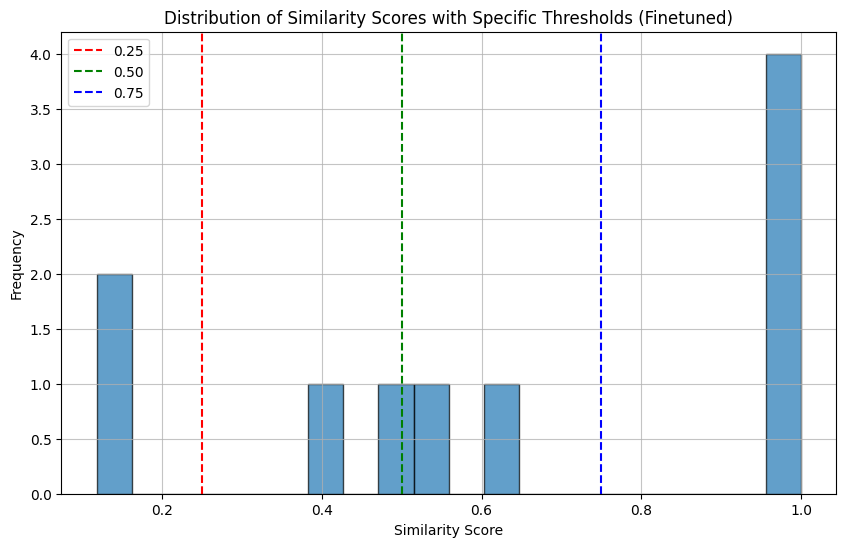

In [ ]:
import matplotlib.pyplot as plt

# Generate histogram of similarity scores
plt.figure(figsize=(10, 6))
plt.hist(df['similarity_score'], bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribution of Similarity Scores with Specific Thresholds (Finetuned)')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')

# Add vertical lines at specific scores
plt.axvline(0.25, color='red', linestyle='dashed', linewidth=1.5, label='0.25')
plt.axvline(0.50, color='green', linestyle='dashed', linewidth=1.5, label='0.50')
plt.axvline(0.75, color='blue', linestyle='dashed', linewidth=1.5, label='0.75')

plt.legend()
plt.grid(axis='both', alpha=0.75) # Ensure grid is visible and covers both axes
plt.show()
